# Evaluating the performance of our retrieval algorithm

And the resulting taxonomy it creates.

In [36]:
import os 
import sys 
import networkx as nx
import matplotlib as mpl
import pprint

# Add the project root directory to the system path

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.etl_module import etl_functions, embedding_functions
from src.processing_module import v0_retrieval
from src.evaluation_module import output_functions, graph_scoring_functions

In [16]:
# Load the document index
document_index = etl_functions.load_documents()

# Embed the document index
embedded_index = embedding_functions.embed_index(document_index)

# Create the graph
graph = graph_scoring_functions.construct_graph(
    embedded_index,
    v0_retrieval.retrieve_top_k,
    edge_threshold=0.5,
    k=5
)

graph_eval = graph_scoring_functions.evaluate_graph(graph)

Constructing Graph: 100%|██████████| 197/197 [00:05<00:00, 36.25it/s]


In [17]:
# View the results without the communities (as its long)
{k: v for k, v in graph_eval.items() if k != 'communities'}

{'number_of_nodes': 197,
 'number_of_edges': 562,
 'average_degree': 5.7055837563451774,
 'density': 0.029110121205842745,
 'clustering_coefficient': 0.3826222713078177,
 'average_node_connectivity': 4.21972443799855,
 'edge_connectivity': 2,
 'node_connectivity': 2,
 'average_shortest_path_length': 4.086915984667979,
 'diameter': 8,
 'degree_assortativity': 0.004376782266041703,
 'source_assortativity': 0.04014279843846328,
 'page_assortativity': 0.0016052546081050138,
 'date_assortativity': 0.04014279843848181,
 'num_communities': 9,
 'community_modularity': 0.66797556454332,
 'precision_lclglbl': 0.7904937701892016,
 'recall_lclglbl': 0.7258883248730964,
 'f1_lclglbl': 0.7030144367982112,
 'precision_harmonic': 1.0,
 'recall_harmonic': 1.0,
 'f1_harmonic': 1.0}

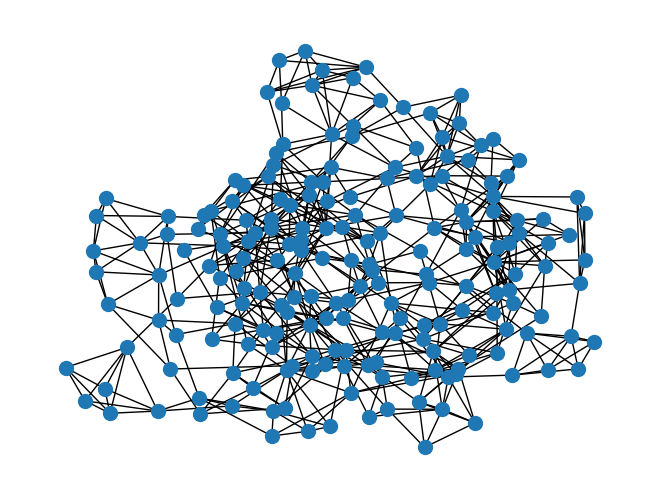

In [18]:
# Visualise the generated graph
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100)

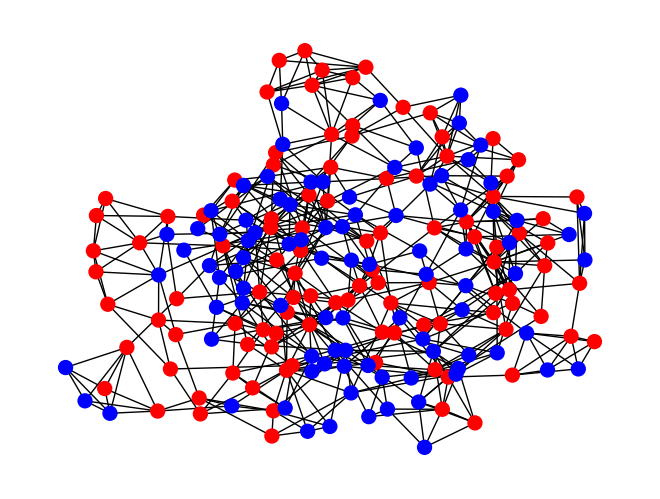

In [19]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in document_index:
    unique_docs.append(doc.metadata['file_name'])
    
set(unique_docs)

colors = []
for n in graph.nodes:
    for doc in document_index:
        if doc.id_ == n:
            if doc.metadata['file_name'] == unique_docs[0]:
                colors.append('red')
            else:
                colors.append('blue')
                
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=colors)

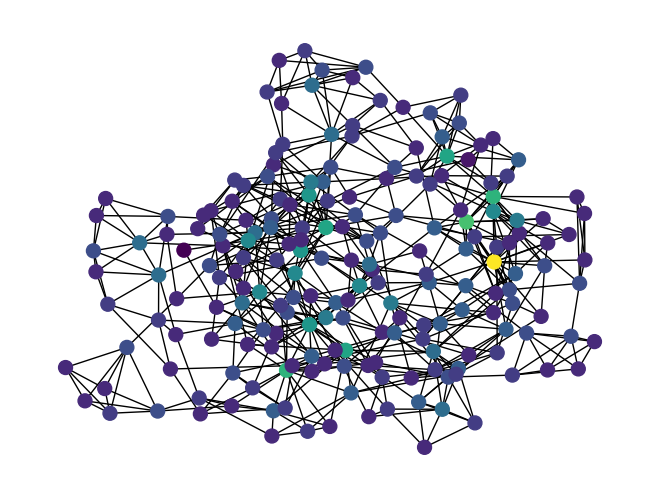

In [28]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=color_map)

## Evaluating the detected communities

The modularity of this method is: 0.66797556454332


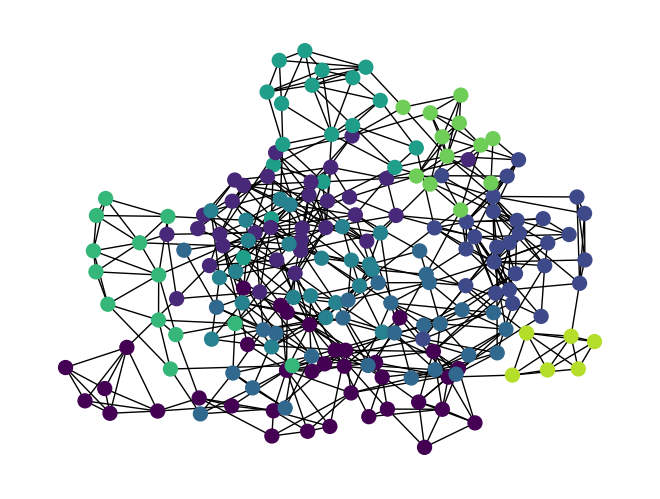

In [31]:
community_node_list = graph_eval['communities']

# Split viridis into n colors
n = len(community_node_list)
viridis = mpl.colormaps['viridis']
colors = [viridis(i/n) for i in range(n)]

# Create a dictionary that maps each community to a color
community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

node_colors = []

for node in graph.nodes:
    # Find which community the node belongs to
    for community, color in community_color_dict.items():
        if node in community:
            node_colors.append(color)

# Draw the graph with the communities colored
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=node_colors)

# Print the modularity of the partition
print("The modularity of this method is:", graph_eval['community_modularity'])

In [38]:
# Do some evaluation for each of the communities detected.
for com_nodes in community_node_list:
    subgraph = graph.subgraph(com_nodes)
    subgraph_eval = graph_scoring_functions.simple_stats(subgraph)
    subgraph_eval2 = graph_scoring_functions.attribute_stats(subgraph)
    
    pprint.pprint(subgraph_eval)
    pprint.pprint(subgraph_eval2)
    
    print("-------------------")

{'average_degree': 4.888888888888889,
 'average_node_connectivity': 2.3380952380952382,
 'average_shortest_path_length': 3.1746031746031744,
 'clustering_coefficient': 0.5899386107719441,
 'density': 0.13968253968253969,
 'diameter': 9,
 'edge_connectivity': 2,
 'node_connectivity': 1,
 'number_of_edges': 88,
 'number_of_nodes': 36}
{'date_assortativity': -0.06526315789184522,
 'degree_assortativity': -0.16132507406409982,
 'page_assortativity': 0.008484354849657231,
 'source_assortativity': -0.06526315789473668}
-------------------
{'average_degree': 4.6875,
 'average_node_connectivity': 3.1733870967741935,
 'average_shortest_path_length': 2.629032258064516,
 'clustering_coefficient': 0.32196293290043293,
 'density': 0.15120967741935484,
 'diameter': 5,
 'edge_connectivity': 1,
 'node_connectivity': 1,
 'number_of_edges': 75,
 'number_of_nodes': 32}
{'date_assortativity': -0.11312217194570136,
 'degree_assortativity': 0.013281249999999788,
 'page_assortativity': -0.031886213628335054,